# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import math
%matplotlib inline

# Load Dataframe & Clean

In [55]:
#Load Dataframe
df = pd.read_csv('data/take-home-test.csv')
#Average duplicate readings for every device and sort.
df = df.groupby(["device_id", "time_in_seconds"], as_index=False).mean().sort(["device_id", "time_in_seconds"])
#Drop heading out of the range 0-360
df = df[(df['heading']>= 0) & (df['heading']<= 360)]
#Print Head
df.head()

/Users/charleslynn/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,device_id,time_in_seconds,id,latitude,longitude,heading
0,0287939c-f943-4fe5-8a9b-bc55b39fd36a,1471963690,12701158,33.012649,-112.106534,343.006348
1,0287939c-f943-4fe5-8a9b-bc55b39fd36a,1471963691,12701161,33.012651,-112.106626,345.585480
2,0287939c-f943-4fe5-8a9b-bc55b39fd36a,1471963692,12701168,33.012651,-112.106716,344.029236
3,0287939c-f943-4fe5-8a9b-bc55b39fd36a,1471963693,12701173,33.012645,-112.106814,179.521060
4,0287939c-f943-4fe5-8a9b-bc55b39fd36a,1471963697,12701184,33.012645,-112.106814,352.071777


# Create New Features

Create the new feature 'heading_change', 'distance_in_degrees', and 'MPH'.

In [56]:
# Differences
df_diff = df.drop(['id', 'device_id'], axis=1).diff(periods=1, axis=0)
df['heading_change'] = df_diff['heading'].abs()
df['distance_in_degrees'] = (df_diff['latitude'].abs()**2 + df_diff['latitude'].abs()**2)**0.5
df['duration_in_seconds'] = df_diff['time_in_seconds'].abs()

# MPH = degrees_distance * 68.94 miles/degree * 3600 sec/hour
# reference: https://www2.usgs.gov/faq/categories/9794/3022
df['MPH'] = df['distance_in_degrees'] * 68.94 * 3600
df = df[df['MPH'] < 100]

df.dropna(inplace=True)
df.head()

,device_id,time_in_seconds,id,latitude,longitude,heading,heading_change,distance_in_degrees,duration_in_seconds,MPH
1,0287939c-f943-4fe5-8a9b-bc55b39fd36a,1471963691,12701161,33.012651,-112.106626,345.585480,2.579132,3.259795e-06,1.0,0.809029
2,0287939c-f943-4fe5-8a9b-bc55b39fd36a,1471963692,12701168,33.012651,-112.106716,344.029236,1.556244,6.519590e-07,1.0,0.161806
3,0287939c-f943-4fe5-8a9b-bc55b39fd36a,1471963693,12701173,33.012645,-112.106814,179.521060,164.508176,8.475468e-06,1.0,2.103476
4,0287939c-f943-4fe5-8a9b-bc55b39fd36a,1471963697,12701184,33.012645,-112.106814,352.071777,172.550717,0.000000e+00,4.0,0.000000
5,0287939c-f943-4fe5-8a9b-bc55b39fd36a,1471963698,12701188,33.012649,-112.106960,332.605927,19.465851,5.571287e-06,1.0,1.382704


# Create Status - Using changes in location and heading

The column 'status' is created in the datafame, based off changes in location and heading.
0 = stopped, 1 = moving, 2 = turning.

In [57]:
#Parameters
heading_tolerance = 15 #Degrees
movement_tolerance = 0.25 #Inches

status = []
for heading_change, distance_in_degrees in zip(df['heading_change'], df['distance_in_degrees']):
    if (heading_change > heading_tolerance) & (heading_change < 360-heading_tolerance):
        status.append(2) # 2 for Turning
    elif distance_in_degrees > movement_tolerance/4353322.4298: #Degreees latitude/longitude to inches. 0.0000000000001:
        status.append(1) # 1 for Moving
    else:
        status.append(0) # 0 for Stopped

df['status'] = status 

# Draw Maps - Stopped, Moving, and Turning

Draw sample maps using matplotlib using the feature 'status' for color.

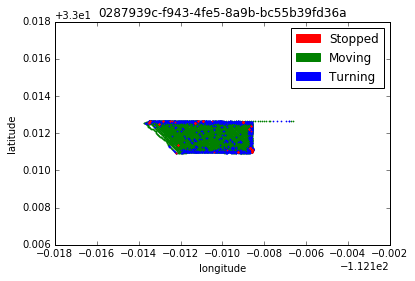

Average MPH:  7.4
Max MPH:  23.7
Time Stopped: 24.62 mins 
Time Moving: 188.57 mins 
Time Turning: 34.73 mins 


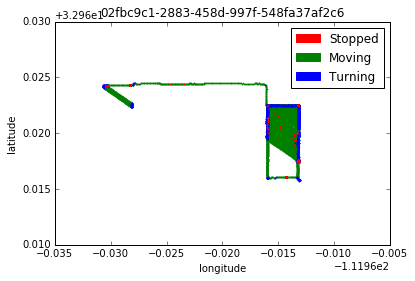

Average MPH:  7.5
Max MPH:  38.3
Time Stopped: 84.12 mins 
Time Moving: 297.73 mins 
Time Turning: 33.37 mins 


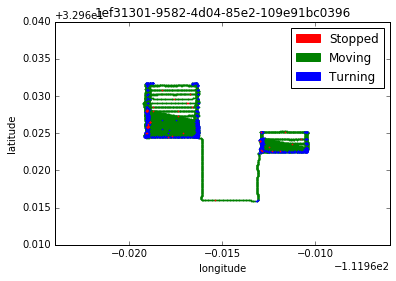

Average MPH:  6.7
Max MPH:  21.4
Time Stopped: 30.18 mins 
Time Moving: 441.95 mins 
Time Turning: 36.53 mins 


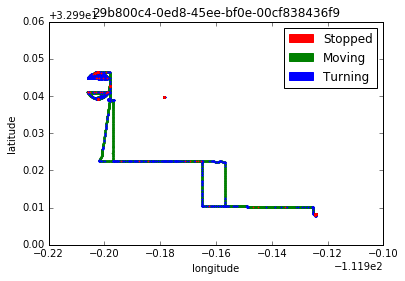

Average MPH:  3.5
Max MPH:  30.9
Time Stopped: 448.65 mins 
Time Moving: 382.37 mins 
Time Turning: 61.52 mins 


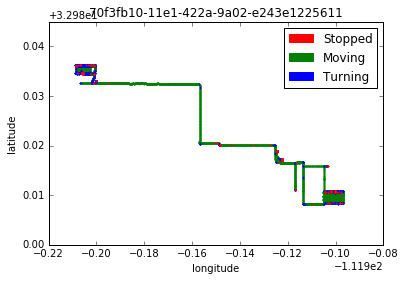

Average MPH:  8.0
Max MPH:  38.7
Time Stopped: 120.5 mins 
Time Moving: 370.12 mins 
Time Turning: 57.82 mins 


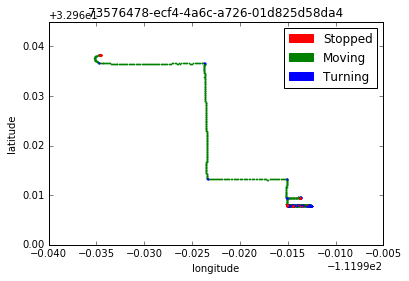

Average MPH:  8.3
Max MPH:  55.2
Time Stopped: 30.83 mins 
Time Moving: 23.67 mins 
Time Turning: 5.5 mins 


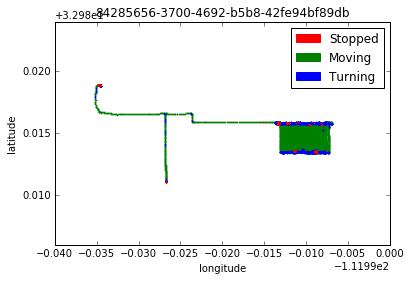

Average MPH:  7.3
Max MPH:  48.4
Time Stopped: 340.5 mins 
Time Moving: 244.38 mins 
Time Turning: 24.98 mins 


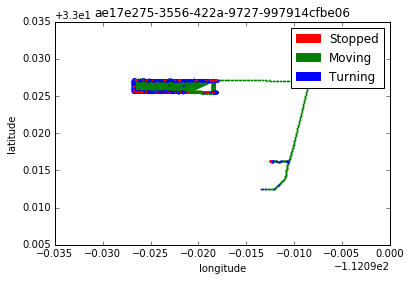

Average MPH:  5.1
Max MPH:  88.0
Time Stopped: 100.8 mins 
Time Moving: 389.52 mins 
Time Turning: 40.05 mins 


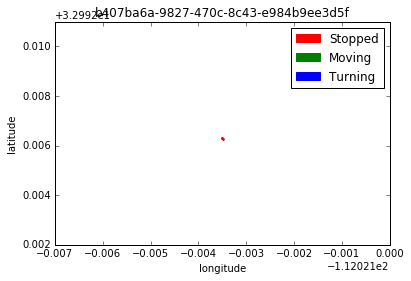

Average MPH:  0.3
Max MPH:  15.2
Time Stopped: 3.92 mins 
Time Moving: 0.05 mins 
Time Turning: 0.02 mins 


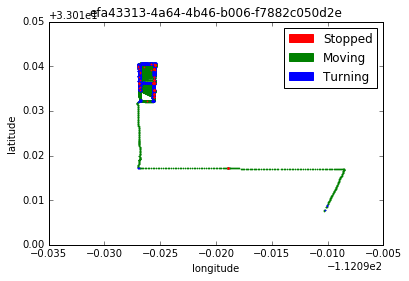

Average MPH:  7.2
Max MPH:  67.5
Time Stopped: 85.5 mins 
Time Moving: 375.5 mins 
Time Turning: 45.27 mins 


In [58]:
for device_id in df['device_id'].unique():
    patches = []
    for status, color in zip([1, 2, 0], ['g', 'b', 'r']):
        plt.scatter(df[(df['device_id']==device_id) & (df['status'] == status)]['longitude'], 
        df[(df['device_id']==device_id) & (df['status'] == status)]['latitude'], lw = 0, c=color, s=3)
    
    patches = []  
    patches.append(mpatches.Patch(color='r', label='Stopped'))
    patches.append(mpatches.Patch(color='g', label='Moving'))
    patches.append(mpatches.Patch(color='b', label='Turning'))
    plt.legend(handles=patches)
    plt.title(device_id)
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.show()
    
    # Print MPH
    print "Average MPH: ", round(df[df['device_id']==device_id]['MPH'].mean(), 1)
    print "Max MPH: ", round(df[df['device_id']==device_id]['MPH'].max(), 1)
    
    # Print time stopped, moving, and turning.
    for status, status_str in zip([0, 1, 2], ['Stopped', 'Moving', 'Turning']):
        print "Time {}: {} mins ".format(status_str, round(df[(df['device_id']==device_id) 
                                                      & (df['status'] == status)]['duration_in_seconds'].sum()/60, 2))
    
    

# Save CSV

In [64]:
# Save csv with staus as a string.
df['status'] = df['status'].map({0:"stopped", 1:"moving", 2:"turning"})
df.to_csv('data/equipment_data.csv', index=False)

# Reset to numerical.
df['status'] = df['status'].map({"stopped":0, "moving":1 , "turning":2})

# Old EDA

In [60]:
df.describe()

,time_in_seconds,id,latitude,longitude,heading,heading_change,distance_in_degrees,duration_in_seconds,MPH,status
count,1.107270e+05,1.107270e+05,110727.000000,110727.000000,110727.000000,110727.000000,110727.000000,110727.000000,110727.000000,110727.000000
mean,1.471975e+09,1.280408e+07,33.010523,-112.056826,176.118380,9.013681,0.000026,2.342654,6.392988,1.006024
std,1.720478e+04,8.462231e+04,0.022124,0.058629,102.743626,33.973328,0.000023,1.803164,5.828496,0.528106
min,1.471910e+09,1.261048e+07,32.967734,-112.117043,0.003881,0.000000,0.000000,1.000000,0.000000,0.000000
25%,1.471970e+09,1.273883e+07,32.990202,-112.110774,93.016541,0.000000,0.000003,2.000000,0.720771,1.000000
50%,1.471978e+09,1.279690e+07,33.012473,-112.098125,175.515091,0.308365,0.000026,2.000000,6.369265,1.000000
75%,1.471987e+09,1.286802e+07,33.027170,-111.998528,270.167733,2.809853,0.000040,2.000000,9.884864,1.000000
max,1.471997e+09,1.300288e+07,33.050696,-111.970396,359.988922,359.527466,0.000355,61.000000,88.007650,2.000000


In [68]:
print len(df[df['device_id']=='0287939c-f943-4fe5-8a9b-bc55b39fd36a'])
print df[df['device_id']=='0287939c-f943-4fe5-8a9b-bc55b39fd36a']['time_in_seconds'].nunique()

7277
7277


In [65]:
df.head()

,device_id,time_in_seconds,id,latitude,longitude,heading,heading_change,distance_in_degrees,duration_in_seconds,MPH,status
1,0287939c-f943-4fe5-8a9b-bc55b39fd36a,1471963691,12701161,33.012651,-112.106626,345.585480,2.579132,3.259795e-06,1.0,0.809029,1
2,0287939c-f943-4fe5-8a9b-bc55b39fd36a,1471963692,12701168,33.012651,-112.106716,344.029236,1.556244,6.519590e-07,1.0,0.161806,1
3,0287939c-f943-4fe5-8a9b-bc55b39fd36a,1471963693,12701173,33.012645,-112.106814,179.521060,164.508176,8.475468e-06,1.0,2.103476,2
4,0287939c-f943-4fe5-8a9b-bc55b39fd36a,1471963697,12701184,33.012645,-112.106814,352.071777,172.550717,0.000000e+00,4.0,0.000000,2
5,0287939c-f943-4fe5-8a9b-bc55b39fd36a,1471963698,12701188,33.012649,-112.106960,332.605927,19.465851,5.571287e-06,1.0,1.382704,2
